# Learning XOR with an Optical network with Kerr-nonlinearities

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Random seed
np.random.seed(11)

In [ ]:
# Runge Kutta ode solver:

def rk4_step(f, y, t, dt, args):
    """Performs a single step of the 4th-order Runge-Kutta method for solving ODEs."""
    k1 = f(t, y, args)
    k2 = f(t + 0.5 * dt, y + 0.5 * dt * k1 * dt, args)
    k3 = f(t + 0.5 * dt, y + 0.5 * dt * k2 * dt, args)
    k4 = f(t + dt, y + k3 * dt, args)
    
    return y + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

def solve_rk4(f, y0, t_span, dt, args):
    """Solves an ODE using RK4 over a time range."""
    t_values = np.arange(t_span[0], t_span[1] + dt, dt)
    y_values = []
    y_values.append(y0)
    
    for i in range(1, len(t_values)):
        y_values.append(rk4_step(f, y_values[i-1], t_values[i-1], dt, args))
    
    return t_values, np.array(y_values)

In [ ]:
# XOR Dataset
inputs = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
targets = np.array([0, 1, 1, 0])

# Parameters
N = 3 # Number of nodes
kappa = np.ones(N)  # Decay rates
g = .2  # Nonlinearity

# Random connectivity matrix:
J = np.random.randn(N, N)  
J = (J + J.T) / 2

"""
For small N (<10), even with a good gradient approx., the method may get stuck 
in bad local minima. The outcome strongly depends on the random initial params.
This is an example of a good initialization (for N=3, kappa_j = 1, g = 0.2):
J = np.array([[ 1.74945474, -1.46969578, -0.51059725],
                    [-1.46969578, -0.00828463, -0.00211435],
                    [-0.51059725, -0.00211435,  0.42105072]])
"""

# Perturbation magnitude
beta = 1e-2  

# System dynamics
def system(t, a, args):
    kappa, g, J, a_in = args
    N = len(kappa)
    dadt = -0.5 * kappa * a - 1j * J @ a - g * 1j * a**2 * a.conj() - np.sqrt(kappa) * a_in
    return dadt

# Simulation time
t_span = (0, 30)
dt = 0.01

# Training

In [ ]:
# Training loop

loss_history = [] 
num_epochs = 200
learning_rate = 0.001

for epoch in range(num_epochs): 
    epoch_loss = 0
    for input_vec, target in zip(inputs, targets):
        # Initial condition
        y0 = np.random.randn(N) + 1j * np.random.randn(N)
        # Set inputs
        a_in = np.zeros(N) + 1j * np.zeros(N)
        a_in[:2] = input_vec + 1j * np.zeros(input_vec.size)

        # Inference Phase
        _, steady_state = solve_rk4(system, y0, t_span, dt, args=(kappa, g, J, a_in))
        a_out = a_in + (kappa)**0.5 * steady_state[-1]
        y = 10*a_out[2].real # network output

        # Compute loss for the current sample
        loss = (y - target)**2    
        epoch_loss += loss

        # Feedback Phase
        y0 = steady_state[-1] # update Cauchy initial condition
        delta_a_in = np.zeros(N) + 1j * np.zeros(N)

        # Error signal w.r.t. U := sigma_y 
        delta_a_in[2] = -1j * beta * 10 * (y - target) 

        # Error signal w.r.t. U := sigma_x 
        #delta_a_in[2] = beta * 10 * (y - target)
        
        a_in += delta_a_in
        _, perturbed_steady_state = solve_rk4(system, y0, t_span, dt, args=(kappa, g, J, a_in))

        delta_a_out = (a_in + (kappa)**0.5 * perturbed_steady_state[-1]) - a_out

        # Update weights
        for j in range(N):
            for l in range(N):
                    # Weight update w.r.t. U := sigma_y
                    dJ_jl = - 2/(kappa[j]*kappa[l])**0.5 * ((a_out[l] - a_in[l])*(delta_a_out[j]-delta_a_in[j]) / beta + (a_out[j] - a_in[j])*(delta_a_out[l]-delta_a_in[l]) / beta).real  

                    # Weight update w.r.t. U := sigma_x
                    #dJ_jl = -2/(kappa[j]*kappa[l])**0.5 * ((a_out[l] - a_in[l])*(delta_a_out[j]-delta_a_in[j]) / beta + (a_out[j] - a_in[j])*(delta_a_out[l]-delta_a_in[l]) / beta).imag 
                    if j == l:
                        # Weight update w.r.t. U := sigma_y
                        dJ_jl = - 2/kappa[j] * ( (a_out[j] - a_in[j])*(delta_a_out[j]-delta_a_in[j]) / beta ).real 

                        # Weight update w.r.t. U := sigma_x
                        #dJ_jl = -2/kappa[j] * ( (a_out[j] - a_in[j])*(delta_a_out[j]-delta_a_in[j]) / beta ).imag 
                        dJ_jl /= 2
                    J[j,l] -= learning_rate * dJ_jl
                    J[l,j] -= learning_rate * dJ_jl 


    # Average loss for the epoch
    epoch_loss = epoch_loss / len(inputs)
    loss_history.append(epoch_loss)


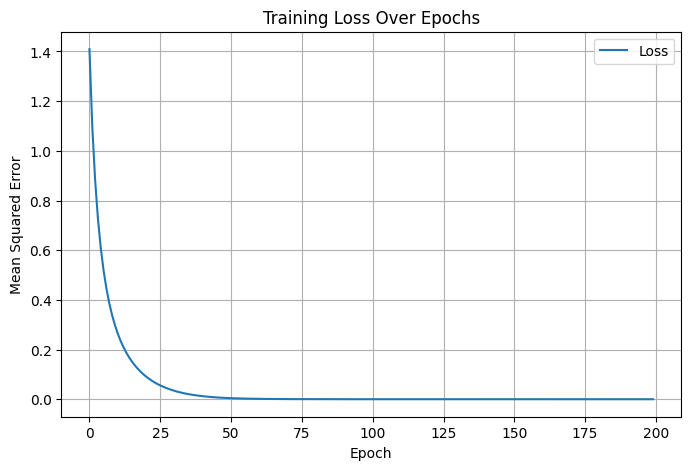

In [21]:
# Plot the loss graph
plt.figure(figsize=(8, 5))
plt.plot(loss_history[:], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

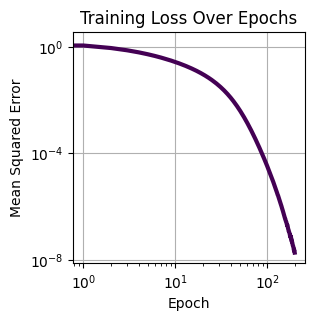

In [26]:
colors = plt.cm.viridis(np.linspace(0, 1, 3))


# Plot the loss graph : x and y in log scale
plt.figure(figsize=(3, 3))
plt.plot(loss_history[:], label='Loss', color = colors[0], linewidth = 3)
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training Loss Over Epochs')
#plt.legend()
plt.grid()
plt.yscale('log')
plt.yticks([1e-0, 1e-4, 1e-8])
plt.xscale('log')
plt.show()

# Evaluation

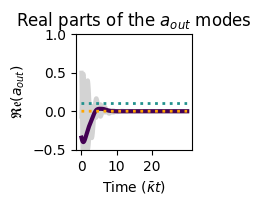

F(0,0) = -0.0


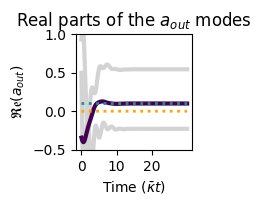

F(0,1) = 0.9998


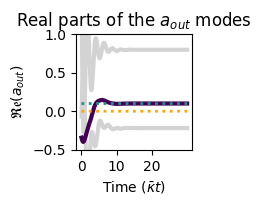

F(1,0) = 0.9999


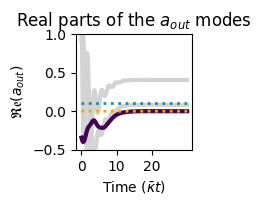

F(1,1) = 0.0


In [ ]:
# Initial condition
np.random.seed(32)
y0 = np.random.randn(N) + 1j * np.random.randn(N)

# Evaluation loop
num_epochs = 1

colors = plt.cm.viridis(np.linspace(0, 1, 3))

t_span = (0, 30)

for epoch in range(num_epochs):  # Number of epochs
    epoch_loss = 0
    for input_vec, target in zip(inputs, targets):
        # Set inputs
        a_in = np.zeros(N) + 1j * np.zeros(N)
        a_in[:2] = input_vec + 1j * np.zeros(input_vec.size)

        # Inference Phase
        t_vals, steady_state = solve_rk4(system, y0, t_span, dt, args=(kappa, g, J, a_in))
        a_out = np.tile(a_in, (steady_state.shape[0],1)) + (kappa)**0.5 * steady_state

        # Plot the trajectory
        num_points = 1000

        # Plot the results for x and p components (multiplied by a factor of 10)
        plt.figure(figsize=(1.5, 1.5))
        plt.xticks(np.array([0., 10., 20.]))
        plt.yticks(np.array([-0.5, 0., 0.5, 1.]))
        for i in range(N):
            if i == 2:  
                plt.plot(t_vals, a_out[:,i].real, label=f"x_{i+1}(t)", color=colors[0], linewidth = 3)  
            else:  
                plt.plot(t_vals, a_out[:,i].real, label=f"x_{i+1}(t)", color='lightgray', linewidth = 3)  
        plt.plot(t_vals, 0.1*np.ones(len(t_vals)), color=colors[1], linestyle = 'dotted', linewidth = 2)
        plt.plot(t_vals, 0*np.ones(len(t_vals)), color='orange', linestyle = 'dotted', linewidth = 2)
        plt.ylim((-0.5,1.))
        plt.xlabel(r'Time ($\bar{\kappa}t$)')
        plt.ylabel(r'$\mathfrak{Re}(a_{out})$')
        plt.title(r'Real parts of the $a_{out}$ modes')
        plt.show()

        print(f"F({input_vec[0]},{input_vec[1]}) = {np.round(10*a_out[-1,2].real,4)}")

